In [1]:
import numpy as np

import forward.common as common
import forward.homogeneous_semi_inf as hsi
import utils.noise as noise
import inverse.fit_homogeneous_semi_inf as fhsi
import inverse.mbl_homogeneous_semi_inf as mbl
import matplotlib.pyplot as plt
import scipy.io as sio

In [24]:
# Load actual tau
data = "C:/Users/marco/OneDrive - Politecnico di Milano/Dottorato/Misure/2024-02-08_Pecore/2024-02-08_Pecore_1s.mat"
a = sio.loadmat(data, struct_as_record=False)
tau = np.array(a["tau"][0][0]).reshape((217,))
tau = tau[tau > 1e-7]
del a

# Generate some curves

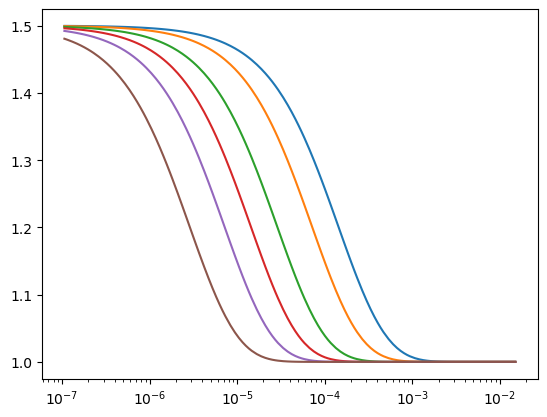

In [25]:
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
v_ms = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4]
beta = 0.5
g1_norm = np.zeros((len(tau), len(db)))
g2_norm = np.zeros((len(tau), len(db)))
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm = 1 + beta * g1_norm**2
plt.semilogx(tau, g2_norm)
plt.show()

# Add noise

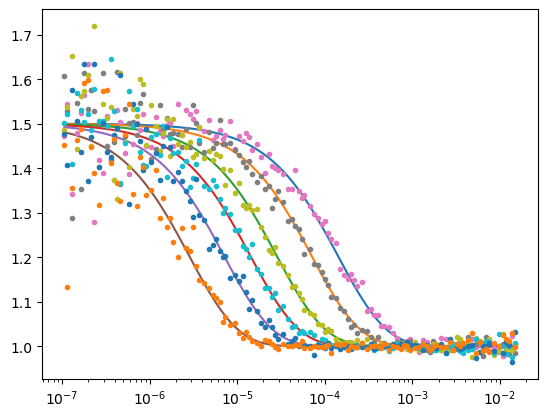

In [34]:
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm,
    tau=tau,
    t_integration=1,
    countrate=8e4,
    beta=0.5,
    n_speckle=1,
    mua=mua,
    musp=musp,
    db=np.array(db),
    lambda0=lambda0
)

g2_norm_noisy = noise_adder.add_noise()
plt.semilogx(tau, g2_norm)
plt.semilogx(tau, g2_norm_noisy, linestyle='none', marker='.')
plt.show()

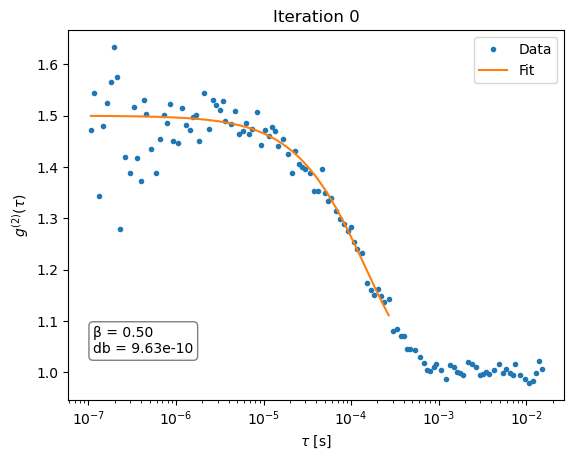

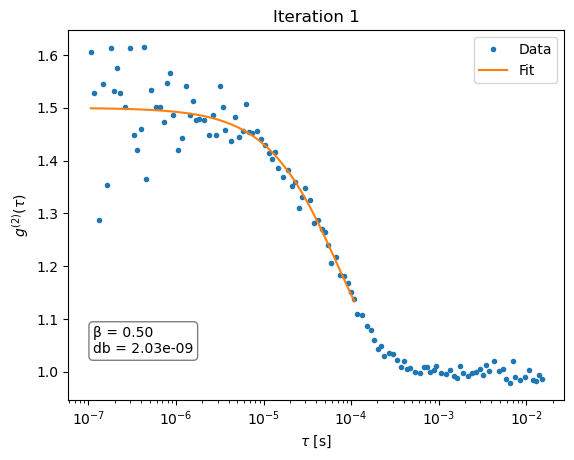

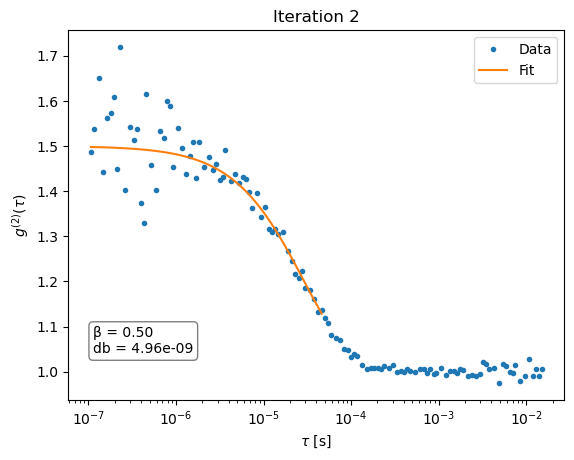

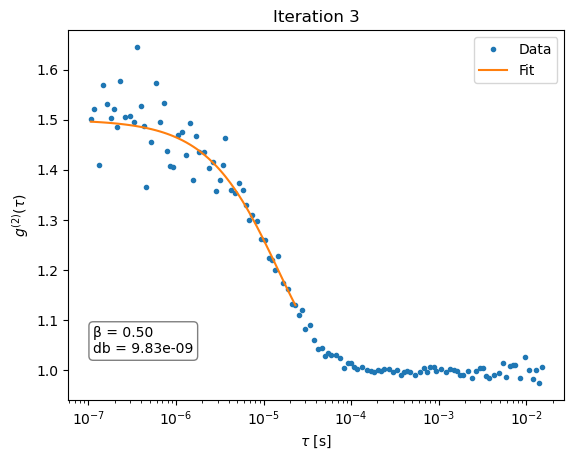

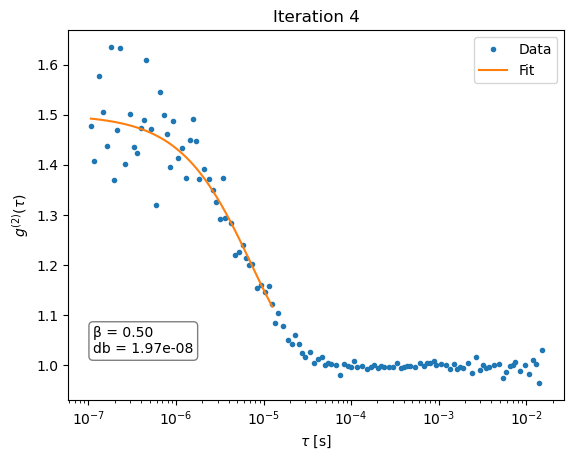

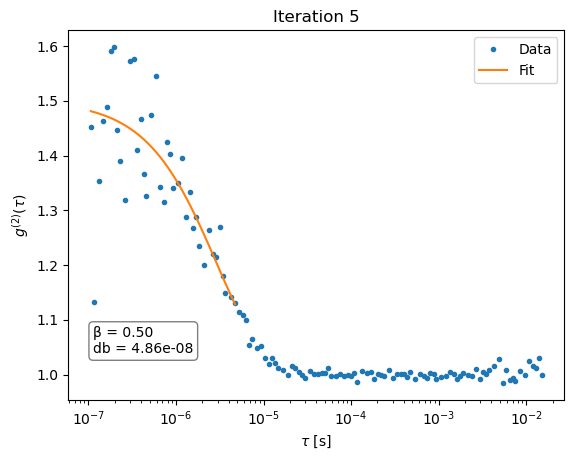

,db,beta
0,9.634942e-10,0.5
1,2.031246e-09,0.5
2,4.959864e-09,0.5
3,9.828772e-09,0.5
4,1.969804e-08,0.5
5,4.860017e-08,0.5


In [59]:
beta_calculator =  fhsi.BetaCalculator(mode="fixed", beta_fixed=0.50)
#beta_calculator = fhsi.BetaCalculator(mode="raw", tau_lims=(1e-7, 2e-7))
#beta_calculator = fhsi.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.45, 0.51))
msd_model = fhsi.MSDModel(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fhsi.MSDModel(model_name="ballistic", param_init={"v_ms": 1e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fhsi.MSDModel(model_name="hybrid", param_init={"db": 1e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fhsi.FitHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.12,
    plot_interval=1
)

fitted_data = fitter.fit()
fitted_data

C:\Users\marco\PycharmProjects\Fit-DCS\inverse\mbl_homogeneous_semi_inf.py:115: RuntimeWarning: invalid value encountered in log
  delta_od = -np.log((self.g2_norm - 1) / (g2_norm_0 - 1))


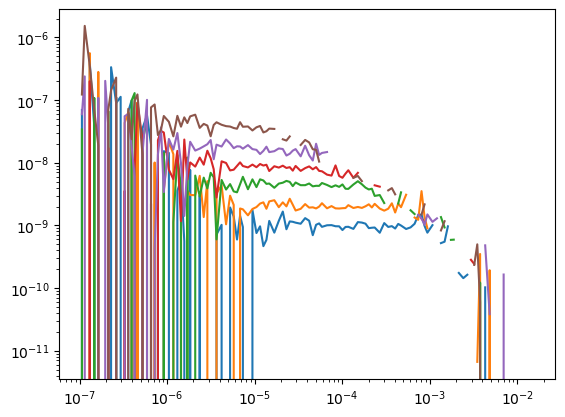

array([9.48206241e-10, 1.87852239e-09, 3.87013778e-09, 7.38437803e-09,
       1.41309842e-08, 2.50626949e-08])

In [38]:
mbl_analyzer = mbl.MBLHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    g2_norm[:, 0],
    mua,
    musp,
    db[0]
)

db_calculated = mbl_analyzer.fit()
plt.loglog(tau, db_calculated)
plt.show()

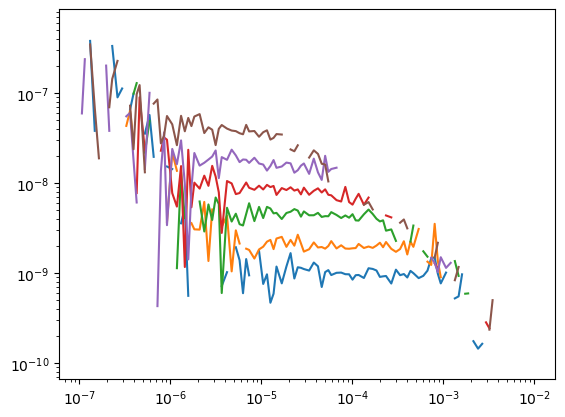

array([1.02097441e-09, 2.01313490e-09, 4.37542045e-09, 8.04754460e-09,
       1.56228284e-08, 3.27815822e-08])

In [54]:
# Plot only the db values that are neither too big (1e-6) nor too small (1e-10)
db_calculated_plot = np.where((db_calculated > 1e-10) & (db_calculated < 1e-6), db_calculated, np.nan)
plt.figure()
plt.loglog(tau, db_calculated_plot)
plt.show()

np.nanmedian(db_calculated_plot, axis=0)